In [1]:
# @title 0. Environnement Preparation

# 1. Packages
# **Download packages
!pip install opencv-python kagglehub tensorflow -q

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# **Load requested libraires
import kagglehub
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import seaborn as sns


from PIL import Image
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2025-05-21 18:33:33.898520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747852414.180423      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747852414.259569      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# 2. Datasets

path_tumors_images = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
path_normal_images = kagglehub.dataset_download("trainingdatapro/dicom-brain-dataset")

print(
    f"Path of MRI with tumors: {path_tumors_images}\n"
    f"Path of Normal MRI images: {path_normal_images}"
)

Path of MRI with tumors: /kaggle/input/brain-tumor-mri-dataset
Path of Normal MRI images: /kaggle/input/dicom-brain-dataset


In [5]:
# 2.1. Brain Tunor Dataset
# **Get Testing and Training datasets
"""
Note: I want to have:
   - "/kaggle/input/brain-tumor-mri-dataset/Testing"
   - "/kaggle/input/brain-tumor-mri-dataset/Training"
"""

paths_tumors_img = {}
data_type = ["Training", "Testing"]

for d_type in data_type:
    paths_tumors_img[f"path_{d_type}"] = os.path.join(path_tumors_images, d_type)

# --Define new keys' name in the dictionary paths_tumors_img
new_keys_names = [f"{d_type}_set" for d_type in data_type]

# --Change keys name in the dictionary paths_tumors_img
for i, key in enumerate(list(paths_tumors_img.keys())):
    paths_tumors_img[new_keys_names[i]] = paths_tumors_img.pop(key)

# --Quick check
paths_tumors_img

{'Training_set': '/kaggle/input/brain-tumor-mri-dataset/Training',
 'Testing_set': '/kaggle/input/brain-tumor-mri-dataset/Testing'}

In [6]:
# **Load images
"""
Note: I'm going to load Training images and Testing images
"""

# --Define tumors categories
tumors_categories = ["glioma", "meningioma", "notumor", "pituitary"]

# --Laod MRI images with tumors --> Training
train_tumors_images = {}
total_train_tumors_images_loaded = 0

for category in tumors_categories:
    category_path = os.path.join(paths_tumors_img['Training_set'], category)
    train_tumors_images[category] = []

    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(category_path, filename)
            img = Image.open(img_path)
            train_tumors_images[category].append(img)
            total_train_tumors_images_loaded += 1

# --Quick check
for key, value in train_tumors_images.items():
    print(f"{key}: {len(value)} images loaded")

# Shape of Train_set
print(
    f"\n*************************\n"
    f"Training Tumor dataset contains: {total_train_tumors_images_loaded} images"
)


glioma: 1321 images loaded
meningioma: 1339 images loaded
notumor: 1595 images loaded
pituitary: 1457 images loaded

*************************
Training Tumor dataset contains: 5712 images


In [7]:
# --Laod MRI images with tumors --> Testing
test_tumors_images = {}
total_test_tumors_images_loaded = 0

for category in tumors_categories:
    category_path = os.path.join(paths_tumors_img['Testing_set'], category)
    test_tumors_images[category] = []

    for filename in os.listdir(category_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(category_path, filename)
            img = Image.open(img_path)
            test_tumors_images[category].append(img)
            total_test_tumors_images_loaded += 1

# --Quick check
for key, value in test_tumors_images.items():
    print(f"{key}: {len(value)} images laoded")

# Shape of Test_set
print(
    f"\n*************************\n"
    f"Testing Tumor dataset contains: {total_test_tumors_images_loaded} images"
)

glioma: 300 images laoded
meningioma: 306 images laoded
notumor: 405 images laoded
pituitary: 300 images laoded

*************************
Testing Tumor dataset contains: 1311 images


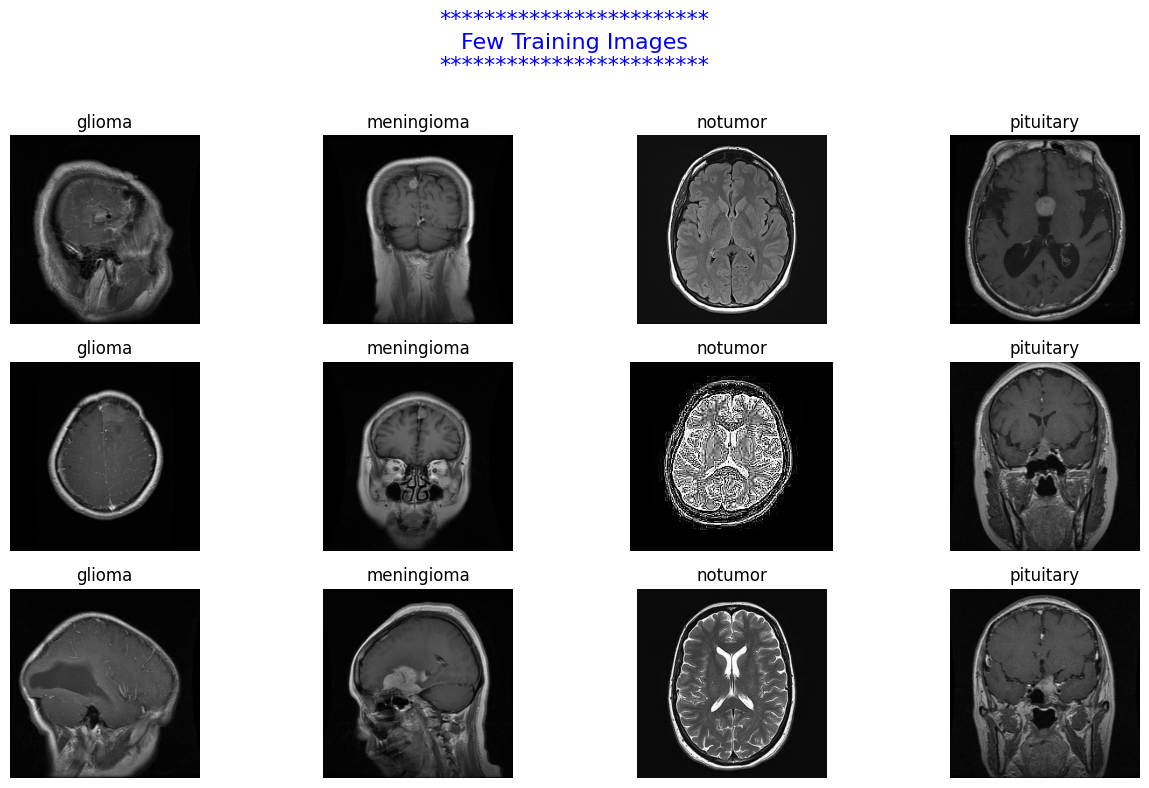

In [8]:
# **Plot some images with Tumors
"""
Note: I'm going to display only 12 MRI images with tumors from the Training repository.
        I'm assuming that if it works here, it'll work also for Testing repository.
"""

# --Define images to plot
img1 = train_tumors_images["glioma"][0]
img2 = train_tumors_images["meningioma"][5]
img3 = train_tumors_images["notumor"][7]
img4 = train_tumors_images["pituitary"][12]
img5 = train_tumors_images["glioma"][10]
img6 = train_tumors_images["meningioma"][2]
img7 = train_tumors_images["notumor"][12]
img8 = train_tumors_images["pituitary"][4]
img9 = train_tumors_images["glioma"][7]
img10 = train_tumors_images["meningioma"][3]
img11 = train_tumors_images["notumor"][4]
img12 = train_tumors_images["pituitary"][1]

# --Convert color format RGB -used by PIL- into format BGR -used by OpenCV-
imgs = [img1, img2, img3, img4, img5, img6, img7, img8, img9, img10, img11, img12]
imgs_cv2 = []

for img in imgs:
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    imgs_cv2.append(img_cv2)

# --Create figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13,8))

# --Display images
for i in range(3):
    for j in range(4):
        index = i * 4 + j
        if index < len(imgs_cv2):
            axes[i, j].imshow(cv2.cvtColor(imgs_cv2[index], cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(tumors_categories[index % len(tumors_categories)])
            axes[i, j].axis('off')

# **Adjust spaces between graphs and display
fig.suptitle(f"************************\nFew Training Images\n************************\n", fontsize=16, color="blue")
plt.tight_layout()
plt.show()

In [9]:
# @title 1. Data Preparation

# 1. Apply filters
"""
Note: Here, I'm going to apply same filters. Currently, I don't have much knownledge on which filter
      apply. Threfore, I'm just going to apply filters seen in course.
      * Denoising (Lissage - fr): Reduce image noise while preserving edges and important details.
        - Gaussian filter
        - Medium filter
        - Bilateral filter --> not seen yet
      * Edge Enhancement (Amélioration des contours - fr)
        - Sobel filter
        - Canny filter --> A multi-step algorithm that detects edges with great precision.
      *  Increase contrast: Increase the intensity difference between light and dark regions of the image,
              which can make tumors more visible.
        - CLAHE (Contrast Limited Adaptive Histogram Equalization): Applies histogram equalization
              locally to avoid amplifying noise.
"""


"\nNote: Here, I'm going to apply same filters. Currently, I don't have much knownledge on which filter\n      apply. Threfore, I'm just going to apply filters seen in course.\n      * Denoising (Lissage - fr): Reduce image noise while preserving edges and important details.\n        - Gaussian filter\n        - Medium filter\n        - Bilateral filter --> not seen yet\n      * Edge Enhancement (Amélioration des contours - fr)\n        - Sobel filter\n        - Canny filter --> A multi-step algorithm that detects edges with great precision.\n      *  Increase contrast: Increase the intensity difference between light and dark regions of the image,\n              which can make tumors more visible.\n        - CLAHE (Contrast Limited Adaptive Histogram Equalization): Applies histogram equalization\n              locally to avoid amplifying noise.\n"

In [10]:
# **Denosing blur
"""
Note: Here, I'm going to display some image vs blured image. So :
  - Ligne 1: Images originales
  - Ligne 2: Images avec filtre gaussien
  - Ligne 3: Images avec filtre médian
  - Ligne 4: Images avec filtre bilatéral
  - Ligne 5: Images avec filtre Canny --> Best blur for MRI images
"""

def apply_and_display_filters(images_dict, num_images_to_display=6):
    # Get the first num_images_to_display images from the first category
    first_category = list(images_dict.keys())[0]  # Get the first category name
    images_to_process = images_dict[first_category][:num_images_to_display]

    fig, axes = plt.subplots(4, num_images_to_display, figsize=(20, 12))

    for i, img_pil in enumerate(images_to_process):
        img_np = np.array(img_pil)

        # Check if the image is grayscale or has only one channel and convert to 3 channels if necessary
        if img_np.ndim == 2 or (img_np.ndim == 3 and img_np.shape[2] == 1):
            img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)

        # Apply filters
        blurred_gaussian_img = cv2.GaussianBlur(img_np, (5, 5), 0)
        blurred_median_img = cv2.medianBlur(img_np, 5)
        blurred_bilateral_img = cv2.bilateralFilter(img_np, 9, 75, 75)

        gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale for Canny
        canny_img = cv2.Canny(gray_img, 100, 200)

        # Display images
        axes[0, i].imshow(blurred_gaussian_img)
        axes[0, i].set_title(f'Gaussian')

        axes[1, i].imshow(blurred_median_img)
        axes[1, i].set_title(f'Median')

        axes[2, i].imshow(blurred_bilateral_img)
        axes[2, i].set_title(f'Bilateral')

        axes[3, i].imshow(canny_img, cmap='gray')
        axes[3, i].set_title(f'Canny')

        # Turn off axis for all subplots
        for k in range(4):
            axes[k, i].axis('off')

    plt.tight_layout()
    plt.show()

"""Note: Use Seuillage 270 bur instead of Canni bur."""

'Note: Use Seuillage 270 bur instead of Canni bur.'

Filter on Train Tumors images
*****************************



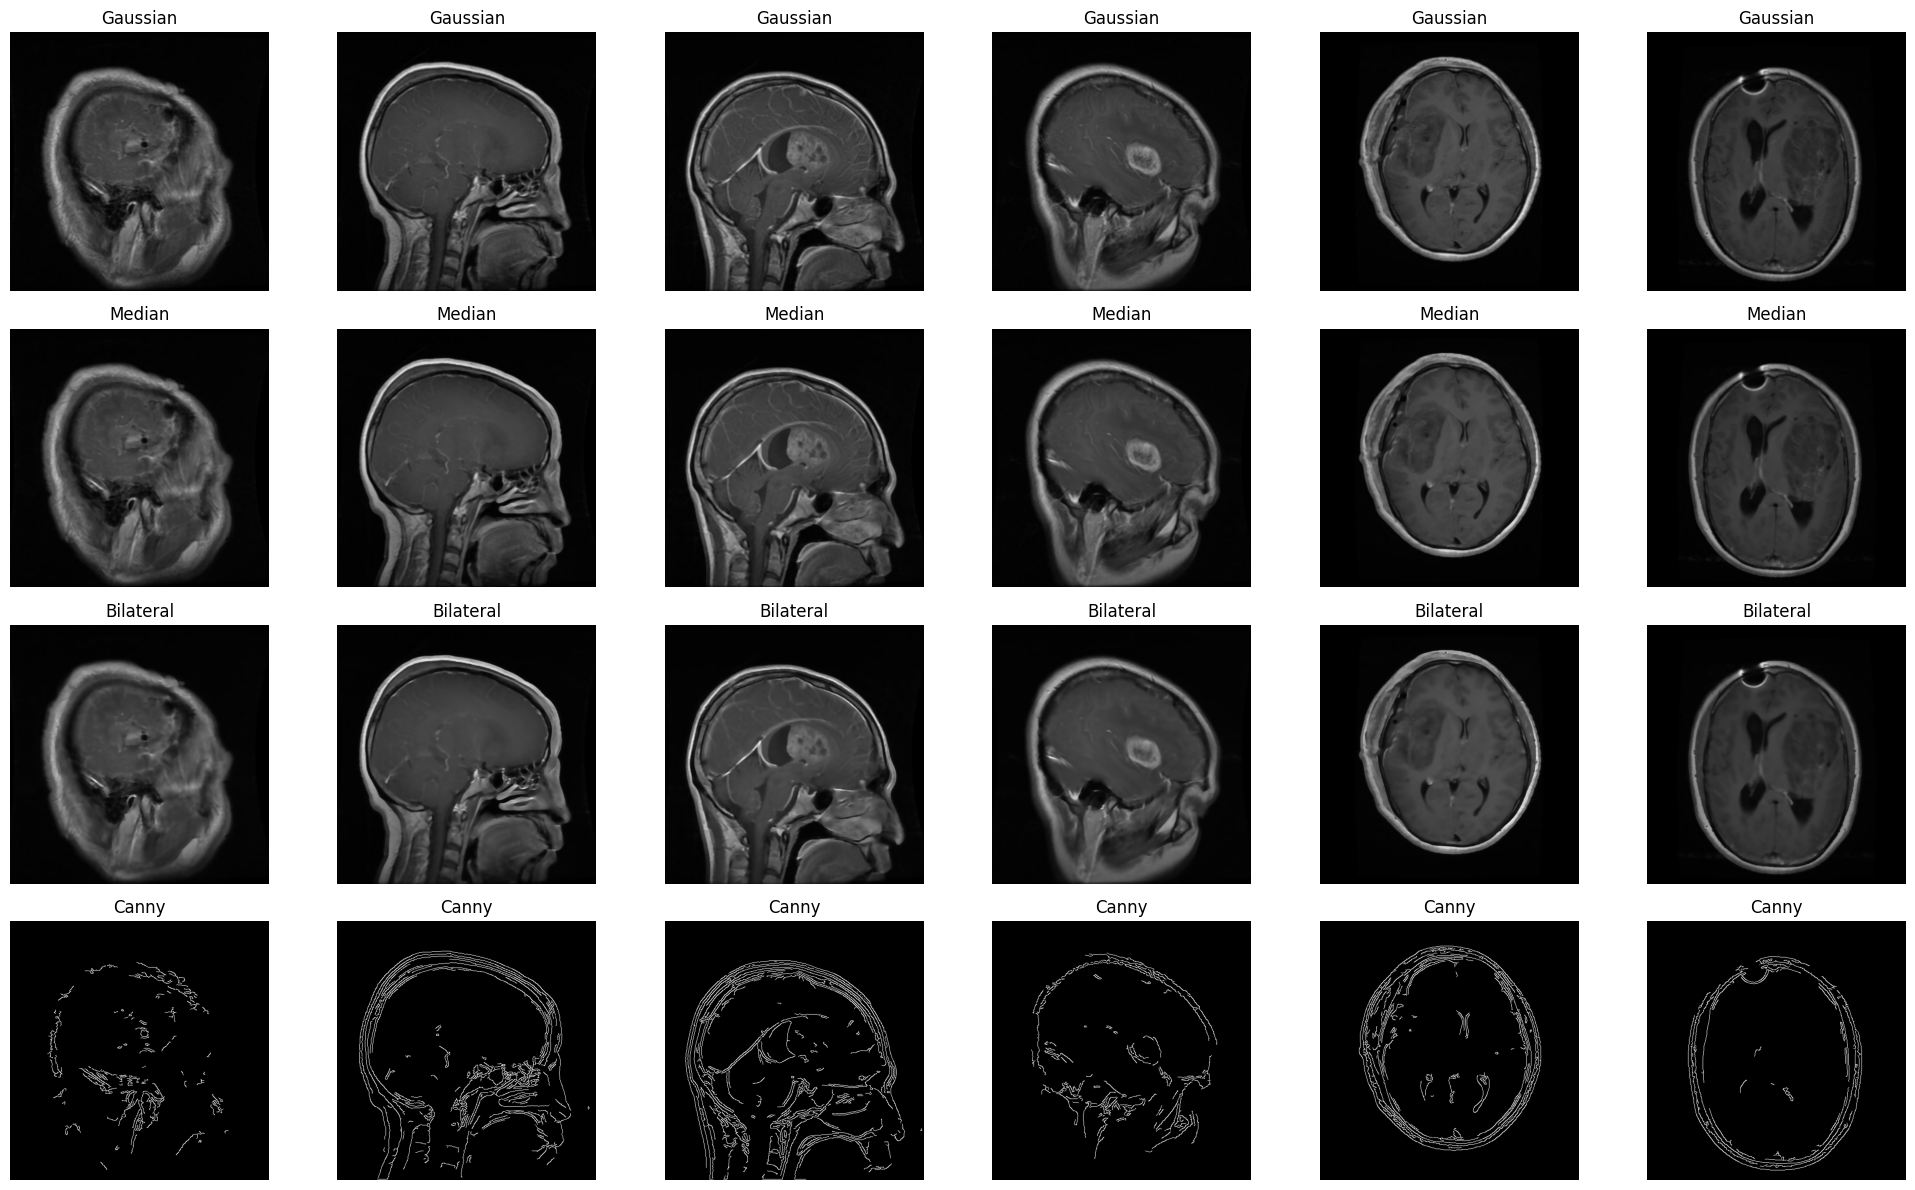

In [11]:
# Call the function to apply and display the filters
print(f"Filter on Train Tumors images\n*****************************\n")
apply_and_display_filters(train_tumors_images)

Filter on Test Tumors images
*****************************



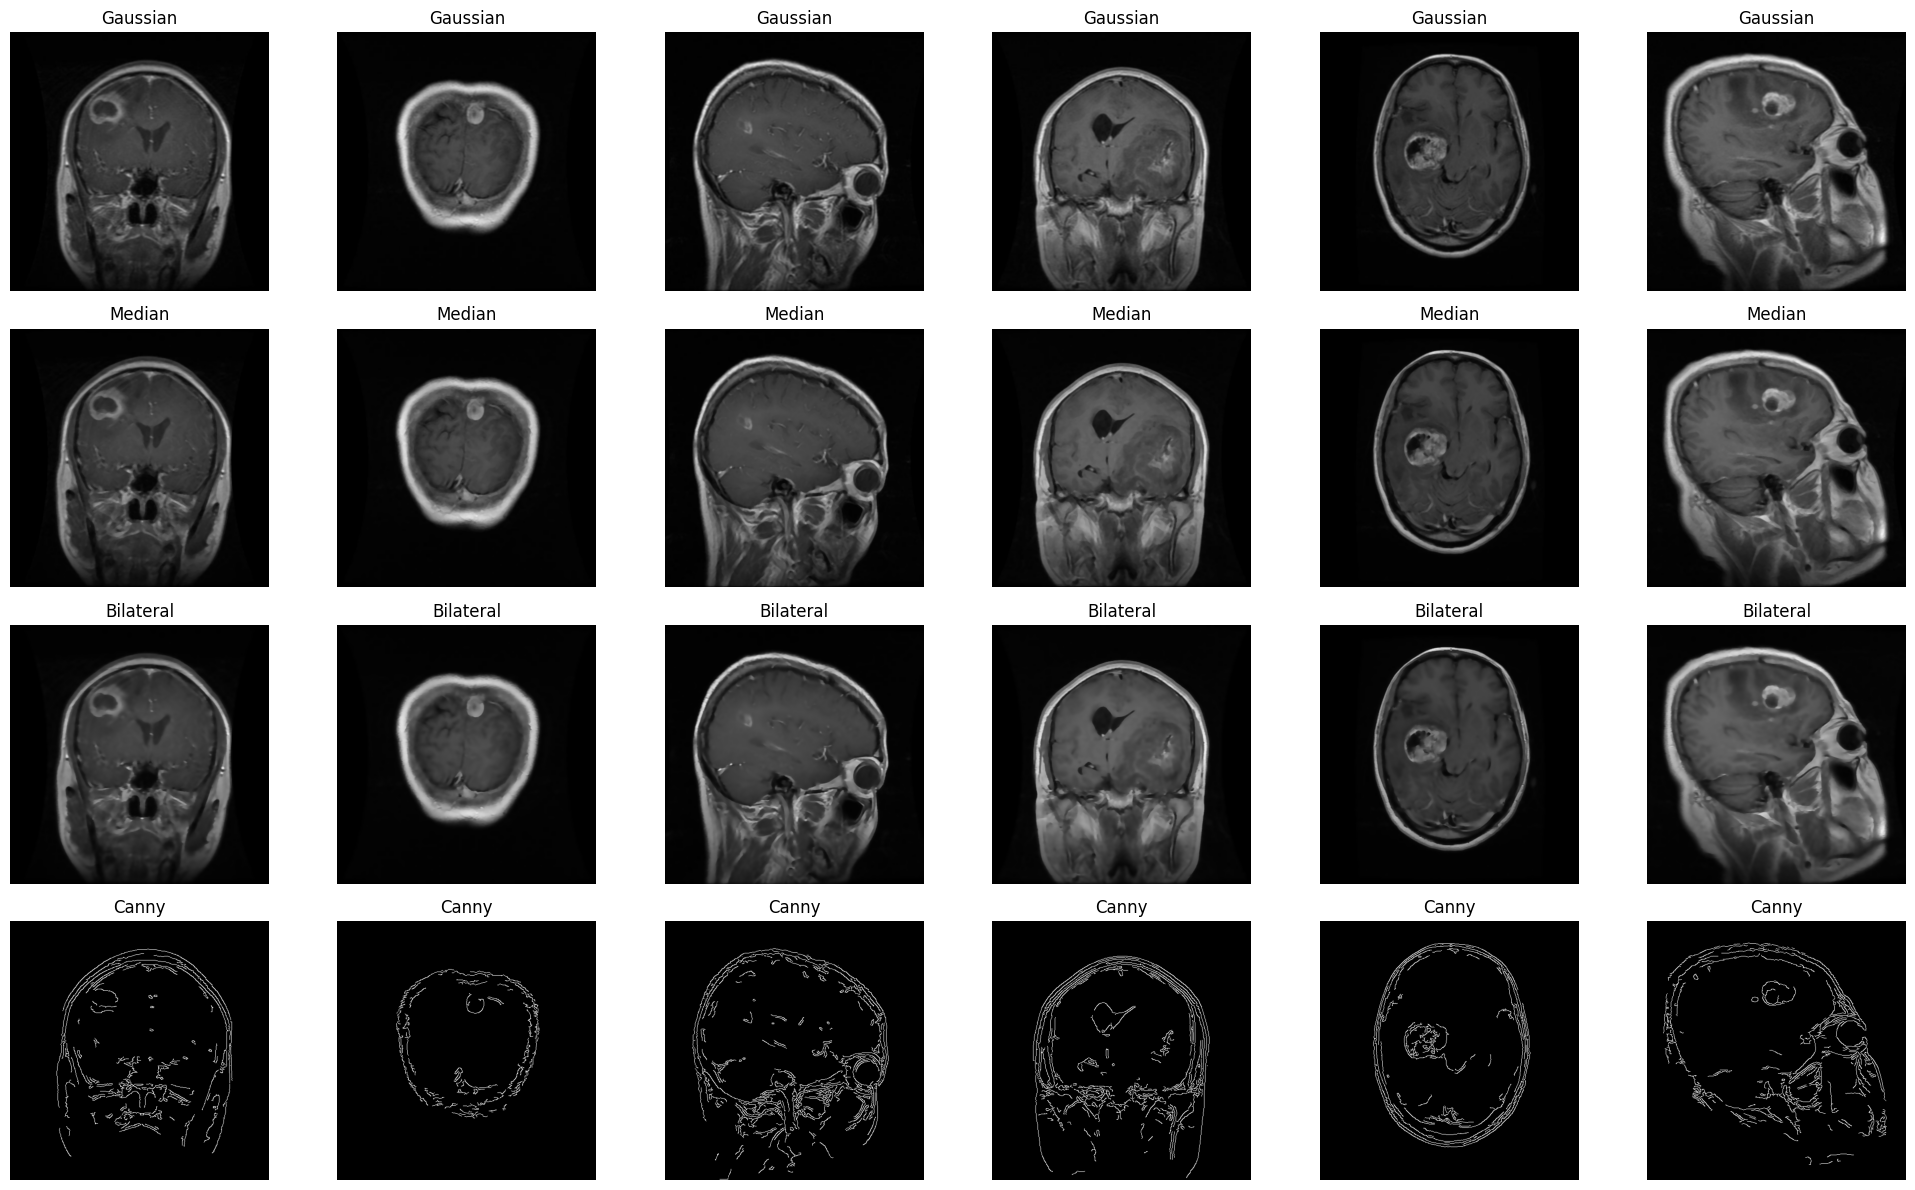

In [12]:
# Apply the function on test_tumors_images
print(f"Filter on Test Tumors images\n*****************************\n")
apply_and_display_filters(test_tumors_images)

In [13]:
# **Get images shapes (for a few one)

def check_and_display_image_dimensions(images_dict):
    first_shape = None  # Initialize with None
    all_shapes = []
    smallest_shape = None  # Initialize with None
    different_shapes = set()  # Use a set to store unique shapes

    for category in images_dict.keys():
        for image in images_dict[category]:
            img_np = np.array(image)
            current_shape = img_np.shape
            all_shapes.append(current_shape)

            if first_shape is None:
                first_shape = current_shape
            elif current_shape != first_shape:
                different_shapes.add(current_shape)  # Add to set if different

            # Update smallest_shape if current shape is smaller
            if smallest_shape is None or np.prod(current_shape) < np.prod(smallest_shape):
                smallest_shape = current_shape

    if len(different_shapes) > 0:
        print("Images in train_tumors_images have different dimensions.")
        print("Different dimensions found:")
        for shape in different_shapes:
            print(shape)
    else:
        print("All images in train_tumors_images have the same dimensions.")

    shape_counts = Counter(all_shapes)
    most_frequent_shape = shape_counts.most_common(1)[0][0]
    print(f"Most frequent image dimensions: {most_frequent_shape}")
    print(f"Smallest image dimensions: {smallest_shape}")


# Check and display dimensions for train_tumors_images
check_and_display_image_dimensions(train_tumors_images)

Images in train_tumors_images have different dimensions.
Different dimensions found:
(395, 367, 3)
(290, 236, 3)
(717, 717, 3)
(302, 216, 3)
(245, 206, 3)
(512, 434, 3)
(250, 201, 3)
(274, 230, 3)
(442, 442, 3)
(228, 233, 3)
(480, 853, 3)
(484, 405, 3)
(248, 208, 3)
(417, 428, 3)
(344, 320, 3)
(273, 236, 3)
(236, 236, 3)
(244, 206, 3)
(470, 469, 3)
(214, 229, 3)
(496, 453, 3)
(216, 234, 3)
(439, 645, 3)
(395, 416, 3)
(236, 255, 3)
(342, 323, 3)
(257, 235, 3)
(1080, 1920, 3)
(340, 507, 3)
(222, 233, 3)
(486, 421, 3)
(260, 314, 3)
(512, 416, 3)
(270, 250, 3)
(415, 339, 3)
(301, 275, 3)
(243, 207, 3)
(903, 721, 3)
(300, 227, 3)
(372, 341, 3)
(592, 562, 3)
(282, 230, 3)
(225, 209, 3)
(306, 278, 3)
(361, 642, 3)
(225, 225)
(355, 330, 3)
(228, 236, 3)
(872, 850, 3)
(213, 210, 3)
(223, 224, 3)
(248, 200, 3)
(218, 234, 3)
(320, 497, 3)
(320, 257, 3)
(365, 306, 3)
(248, 257, 3)
(442, 442)
(613, 605, 3)
(239, 236, 3)
(354, 298, 3)
(258, 300, 3)
(280, 236, 3)
(400, 393, 4)
(201, 173, 3)
(228, 228

In [14]:
# Normalization
# --> Normalization to uniformize images shapes (224, 224, 3).
def normalize_image_dimensions(image):
    # Convert the PIL Image to a NumPy array
    img_np = np.array(image)

    # Resize the image to (224, 224)
    resized_img = cv2.resize(img_np, (224, 224))

    # If the image is grayscale or has only one channel, convert it to RGB
    if resized_img.ndim == 2 or (resized_img.ndim == 3 and resized_img.shape[2] == 1):
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2BGR)

    # If the image has 4 channels (RGBA), convert it to RGB
    elif resized_img.shape[2] == 4: # Check if the image has an alpha channel
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGBA2RGB)

    # Check if the image has 3 channels (RGB) after potential conversions
    if resized_img.shape[2] != 3:
        raise ValueError(f"The image has {resized_img.shape[2]} channels after resizing. Check the image format. Shape: {resized_img.shape}")

    return resized_img


# Apply normalized_train_tumors_images on train_tumors_images
normalized_train_tumors_images = {}
for category, images in train_tumors_images.items():
    normalized_train_tumors_images[category] = [normalize_image_dimensions(img) for img in images]

"""Note: Now 'normalized_train_tumors_images' contains the normalized images dimensions."""

"Note: Now 'normalized_train_tumors_images' contains the normalized images dimensions."

In [15]:
# Apply normalized_test_tumors_images on test_tumors_images
normalized_test_tumors_images = {}

for category, images in test_tumors_images.items():
    normalized_test_tumors_images[category] = [normalize_image_dimensions(img) for img in images]

"""Note: 'normalized_test_tumors_images' contains the normalized images."""

"Note: 'normalized_test_tumors_images' contains the normalized images."

In [16]:
# --Quick check --> Check one time again the size of image after apply function

def display_normalized_image_dimensions(normalized_images_dict, num_images_per_category=5):
    for category, images in normalized_images_dict.items():
        # Select random images from the category
        random_images = random.sample(images, min(num_images_per_category, len(images)))

        for i, image in enumerate(random_images):
            print(f"Image {i + 1} in category '{category}' - Dimensions: {image.shape}")


# Display the dimensions of a random selection of normalized images
display_normalized_image_dimensions(normalized_train_tumors_images)

Image 1 in category 'glioma' - Dimensions: (224, 224, 3)
Image 2 in category 'glioma' - Dimensions: (224, 224, 3)
Image 3 in category 'glioma' - Dimensions: (224, 224, 3)
Image 4 in category 'glioma' - Dimensions: (224, 224, 3)
Image 5 in category 'glioma' - Dimensions: (224, 224, 3)
Image 1 in category 'meningioma' - Dimensions: (224, 224, 3)
Image 2 in category 'meningioma' - Dimensions: (224, 224, 3)
Image 3 in category 'meningioma' - Dimensions: (224, 224, 3)
Image 4 in category 'meningioma' - Dimensions: (224, 224, 3)
Image 5 in category 'meningioma' - Dimensions: (224, 224, 3)
Image 1 in category 'notumor' - Dimensions: (224, 224, 3)
Image 2 in category 'notumor' - Dimensions: (224, 224, 3)
Image 3 in category 'notumor' - Dimensions: (224, 224, 3)
Image 4 in category 'notumor' - Dimensions: (224, 224, 3)
Image 5 in category 'notumor' - Dimensions: (224, 224, 3)
Image 1 in category 'pituitary' - Dimensions: (224, 224, 3)
Image 2 in category 'pituitary' - Dimensions: (224, 224, 3)


In [17]:
# **One-Hot Encoding of Categoty
def one_hot_encode(data, categories):
    num_categories = len(categories)
    encoded_data = []

    for item in data:
        one_hot = [0] * num_categories
        try:
            index = categories.index(item)
            one_hot[index] = 1
        except ValueError:
            # Handle cases where the category is not found
            print(f"Warning: Category '{item}' not found in the defined categories. Encoding as all zeros.")
        encoded_data.append(one_hot)
    return np.array(encoded_data)

# Get all image labels train
image_labels_train = []

for category, images in normalized_train_tumors_images.items():
    image_labels_train.extend([category] * len(images))

#  Get all image label test data
image_labels_test = []

for category, images in normalized_test_tumors_images.items():
    image_labels_test.extend([category] * len(images))


# Use the fonction 'one_hot_encode'
tumors_categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Pass the image labels (image_labels_train, image_labels_test) instead of the image data
encoded_labels_train = one_hot_encode(image_labels_train, tumors_categories)
encoded_labels_test = one_hot_encode(image_labels_test, tumors_categories)

In [18]:
# **Convert images into NumPy array
def convert_images_to_numpy_arrays(images_dict):
    numpy_arrays = []
    for category, images in images_dict.items():
        for img in images:
          numpy_arrays.append(np.array(img))
    return np.array(numpy_arrays)


# Use the function to convert the normalized training images to numpy arrays
train_image_arrays = convert_images_to_numpy_arrays(normalized_train_tumors_images)
test_image_arrays = convert_images_to_numpy_arrays(normalized_test_tumors_images)

print(
    f"Shape of training image arrays: {train_image_arrays.shape}\n"
    f"Shape of testing image arrays: {test_image_arrays.shape}"
)


Shape of training image arrays: (5712, 224, 224, 3)
Shape of testing image arrays: (1311, 224, 224, 3)


In [19]:
# **Define X_train, X_val y_train and y_val from Training_set
from sklearn.model_selection import train_test_split

# Assuming train_image_arrays and encoded_labels_train are defined from the previous code
X_train, X_val, y_train, y_val = train_test_split(
    train_image_arrays, encoded_labels_train, test_size=0.2, random_state=42
)

print(
    f"X_train shape: {X_train.shape}\n"
    f"y_train shape: {y_train.shape}\n"
    f"X_val shape: {X_val.shape}\n"
    f"y_val shape: {y_val.shape}"
)

X_train shape: (4569, 224, 224, 3)
y_train shape: (4569, 4)
X_val shape: (1143, 224, 224, 3)
y_val shape: (1143, 4)


In [20]:
# **Getting X_test and y_test
X_test = test_image_arrays
y_test = encoded_labels_test

print(
    f"X_test shape: {X_test.shape}\n"
    f"y_test shape: {y_test.shape}"
)

X_test shape: (1311, 224, 224, 3)
y_test shape: (1311, 4)


In [21]:

# @title 3. Modelisation

# Design CNN Model
# **Model Architecture
"""
  * Input: MRI image
  * Feature extractors: 5 layers, each Convolution + Pooling
  * Classifier: 3 layers
    - Flatten
    - Dense: represent a fully connected
    - Dropout
  * Output: classes images into category
"""


model = models.Sequential()
# --Inmput layer
model.add(layers.Input(shape=(224, 224, 3)))    #(224, 224, 3)= input image size (224,224) and 3->RGB

# --Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
"""Note: 32=nbr of filter in the convolution layer | (3, 3)=convolutional kernel shape"""
model.add(layers.MaxPooling2D((2, 2)))

# --Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# --Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# --Layer 4
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# --Layer 5
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# --Classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

2025-05-21 18:35:19.181163: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:
# **Display the Model Architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,815,364 (14.55 MB)

 Trainable params: 3,815,364 (14.55 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# **Model Compile
"""Good to know: model.compile() prepares the model for training by specifying how it should be optimised, which loss function to use, and which metrics to monitor."""

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
# --> Normalization of pixels values on 255
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

"""Note: Now 'normalized_train_tumors_images' contains the normalized images."""

"Note: Now 'normalized_train_tumors_images' contains the normalized images."

In [25]:
# @title 4.Model Evaluation
# **Modele Evaluation
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val)) # Change later epochs into 30

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5420 - loss: 1.0041 - val_accuracy: 0.8373 - val_loss: 0.4525
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8184 - loss: 0.4733 - val_accuracy: 0.8828 - val_loss: 0.3246
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.8717 - loss: 0.3333 - val_accuracy: 0.9046 - val_loss: 0.2444
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9125 - loss: 0.2310 - val_accuracy: 0.9326 - val_loss: 0.1908
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9414 - loss: 0.1664 - val_accuracy: 0.9449 - val_loss: 0.1754
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9497 - loss: 0.1458 - val_accuracy: 0.9309 - val_loss: 0.2145
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9519 - loss: 0.1264 - val_accuracy: 0.9484 - val_loss: 0.1739
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9665 - loss: 0.0899 - val_accu

41/41 - 23s - 564ms/step - accuracy: 0.9474 - loss: 0.2026


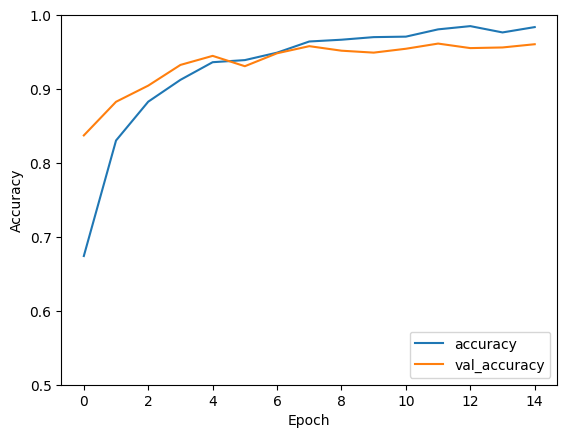

In [26]:
# **Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

In [27]:
print(f"{round(test_acc, 3)}")
"""Note: I get a test accuracy of close to 95%."""

0.947


'Note: I get a test accuracy of close to 91%.'

In [28]:
# Obtenir les prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les prédictions en classes

# Obtenir les vraies étiquettes pour l'ensemble de test
y_true_classes = np.argmax(y_test, axis=1)  # Convertir les vraies étiquettes en classes

# Afficher le rapport de classification
print(
    f"\nClassification Report\n"
    f"********************************\n"
    f"{classification_report(y_true_classes, y_pred_classes, target_names=tumors_categories)}"
)

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 577ms/step

Classification Report
********************************
              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.90      0.90      0.90       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



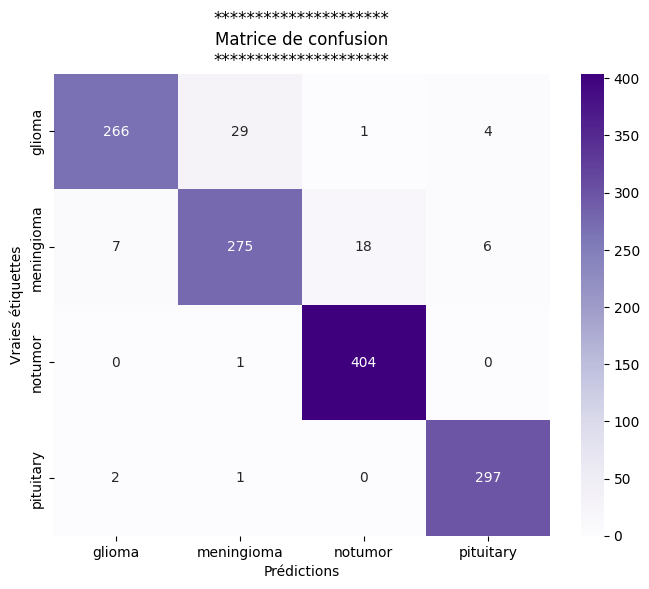

In [29]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Afficher la matrice de confusion à l'aide de seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=tumors_categories, yticklabels=tumors_categories)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("*********************\nMatrice de confusion\n*********************")
plt.show()

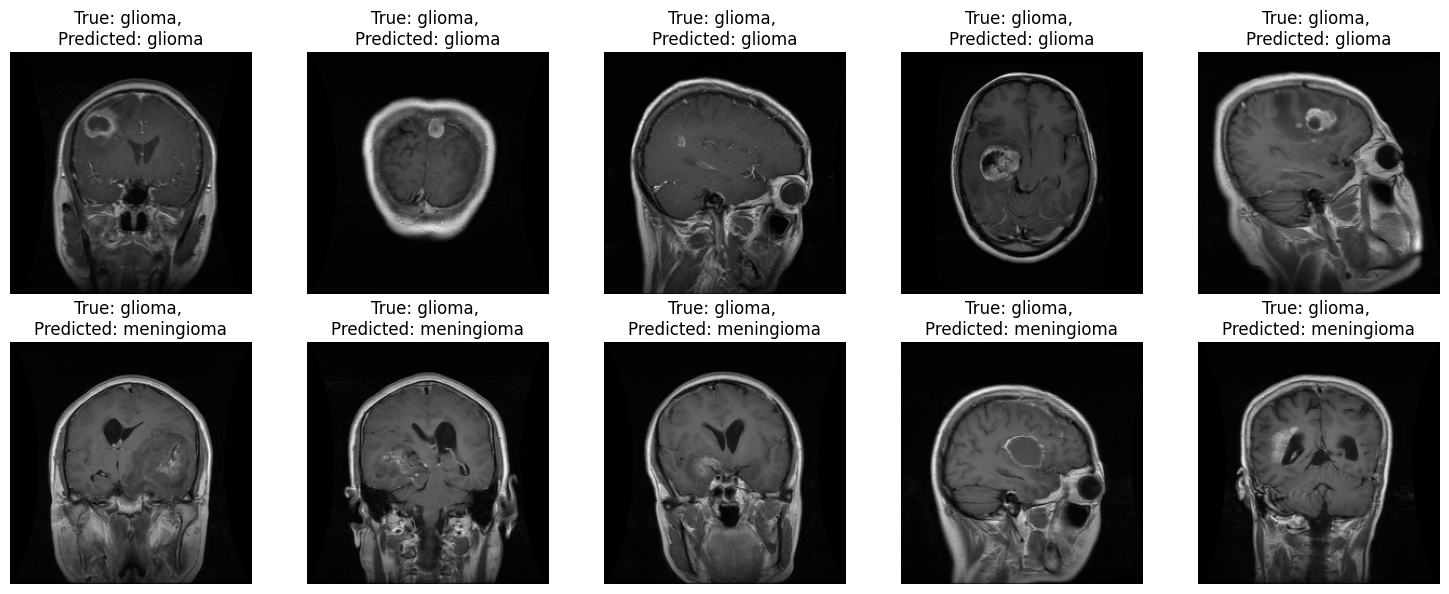

In [30]:
# **Visualise the model's correct and incorrect predictions on a test set

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Display correct and incorrect predictions
num_correct_to_display = 5
num_incorrect_to_display = 5

correct_indices = np.where(y_true_classes == y_pred_classes)[0]
incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]

# Create subplots for 10 images (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

# Display correct predictions
for i, index in enumerate(correct_indices[:num_correct_to_display]):
    row = 0  # First row for correct predictions
    col = i
    axes[row, col].imshow(X_test[index])
    axes[row, col].set_title(f"True: {tumors_categories[y_true_classes[index]]}, \nPredicted: {tumors_categories[y_pred_classes[index]]}")
    axes[row, col].axis('off')

# Display incorrect predictions
for i, index in enumerate(incorrect_indices[:num_incorrect_to_display]):
    row = 1  # Second row for incorrect predictions
    col = i
    axes[row, col].imshow(X_test[index])
    axes[row, col].set_title(f"True: {tumors_categories[y_true_classes[index]]}, \nPredicted: {tumors_categories[y_pred_classes[index]]}")
    axes[row, col].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [31]:
"""
Note:
  - Lien utile: https://www.kaggle.com/code/abdocan/brain-tumor-classification-pytorch-99-7-test
  - Lien utile: https://www.kaggle.com/code/nahidcse/brain-tumor-classification-transfer-learning
"""

"""
PowerPoint contain:

Voici une proposition de structure et de contenu pour votre présentation :

Introduction

Contexte: Commencez par présenter le contexte du projet : la classification des tumeurs cérébrales est un enjeu majeur de santé publique. L'IRM est un outil d'imagerie médicale crucial pour le diagnostic.
Objectif: Expliquez clairement l'objectif du projet : développer un modèle de deep learning capable de classifier automatiquement les tumeurs cérébrales à partir d'images IRM.
Importance: Soulignez l'importance d'une telle solution : gain de temps pour les médecins, amélioration de la précision du diagnostic, meilleure prise en charge des patients.
Données et Préparation

Source des données: Indiquez la provenance des données : Kaggle dataset : "masoudnickparvar/brain-tumor-mri-dataset" et "trainingdatapro/dicom-brain-dataset".
Types de tumeurs: Précisez les types de tumeurs que votre modèle est capable de classifier : glioma, méningiome, pas de tumeur, tumeur hypophysaire.
Préparation des données: Décrivez les étapes de préparation des données :
Prétraitement: Redimensionnement des images, conversion en niveaux de gris si nécessaire, normalisation des intensités des pixels.
Augmentation des données: Si vous avez utilisé des techniques d'augmentation des données, expliquez-les brièvement (rotation, retournement, etc.).
Division des données: Indiquez comment vous avez divisé les données en ensembles d'entraînement, de validation et de test.
Modèle

Architecture: Décrivez l'architecture de votre modèle de deep learning : type de modèle (CNN), nombre de couches, fonctions d'activation, etc. Vous pouvez utiliser un schéma pour illustrer l'architecture.
Entraînement: Expliquez comment vous avez entraîné votre modèle : optimiseur utilisé, fonction de perte, métriques suivies, nombre d'époques, etc.
Évaluation

Métriques: Présentez les métriques que vous avez utilisées pour évaluer les performances de votre modèle : précision, rappel, score F1, matrice de confusion.
Résultats: Montrez les résultats obtenus par votre modèle sur l'ensemble de test. Mettez en évidence les performances atteintes en termes de précision et de robustesse.
Visualisations: Utilisez des graphiques et des visualisations pour illustrer les performances de votre modèle, par exemple, la courbe d'apprentissage, la matrice de confusion, des exemples de prédictions correctes et incorrectes.
Conclusion

Synthèse: Résumez les points clés de votre présentation : l'objectif du projet, la méthode utilisée, les résultats obtenus.
Limites: Discutez des limites de votre modèle et des axes d'amélioration possibles.
Perspectives: Évoquez les perspectives d'avenir pour ce projet, par exemple, l'intégration du modèle dans un outil d'aide au diagnostic.
Conseils supplémentaires

Soyez clair et concis: Adaptez votre présentation au public et utilisez un langage accessible à tous.
Illustrez votre propos: Utilisez des images, des graphiques et des exemples concrets pour rendre votre présentation plus attractive.
Soyez prêt à répondre aux questions: Anticipez les questions que le public pourrait vous poser et préparez des réponses claires et précises.
J'espère que ces éléments vous seront utiles pour préparer votre présentation. N'hésitez pas à me poser d'autres questions si besoin.

"""

'\nPowerPoint contain:\n\nVoici une proposition de structure et de contenu pour votre présentation :\n\nIntroduction\n\nContexte: Commencez par présenter le contexte du projet : la classification des tumeurs cérébrales est un enjeu majeur de santé publique. L\'IRM est un outil d\'imagerie médicale crucial pour le diagnostic.\nObjectif: Expliquez clairement l\'objectif du projet : développer un modèle de deep learning capable de classifier automatiquement les tumeurs cérébrales à partir d\'images IRM.\nImportance: Soulignez l\'importance d\'une telle solution : gain de temps pour les médecins, amélioration de la précision du diagnostic, meilleure prise en charge des patients.\nDonnées et Préparation\n\nSource des données: Indiquez la provenance des données : Kaggle dataset : "masoudnickparvar/brain-tumor-mri-dataset" et "trainingdatapro/dicom-brain-dataset".\nTypes de tumeurs: Précisez les types de tumeurs que votre modèle est capable de classifier : glioma, méningiome, pas de tumeur, t

In [32]:
# DO NOT RUN 
def classification_report_simplified(y_true, y_pred, labels):
    from collections import Counter

    # Compter les vrais positifs, faux positifs, faux négatifs
    tp = Counter()
    fp = Counter()
    fn = Counter()

    for true, pred in zip(y_true, y_pred):
        if true == pred:
            tp[true] += 1
        else:
            fp[pred] += 1
            fn[true] += 1

    # Calculer les métriques
    report = {}
    for label in labels:
        precision = tp[label] / (tp[label] + fp[label]) if (tp[label] + fp[label]) else 0
        recall = tp[label] / (tp[label] + fn[label]) if (tp[label] + fn[label]) else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        support = tp[label] + fn[label] 

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        }
    
    return report

